In [12]:
import os
import torch
from torch.utils.data import Dataset
import torchaudio
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
data_path_train = r'ASVSpoof2019\LA\LA\ASVspoof2019_LA_train\flac'  
protocol_path_train = r'ASVSpoof2019\LA\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.train.trn.txt'  

data_path_test = r'ASVSpoof2019\LA\LA\ASVspoof2019_LA_eval\flac' 
protocol_path_test = r'ASVSpoof2019\LA\LA\ASVspoof2019_LA_cm_protocols\ASVspoof2019.LA.cm.eval.trl.txt'  


In [ ]:
def parse_protocol(protocol_path):
    data_list = []
    with open(protocol_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue  
            
            parts = line.split()
            utt_id = parts[1]  
            label  = parts[-1] 
            
            data_list.append((utt_id, label))
    return data_list

In [ ]:
def get_audio_label_list(data_path, protocol_path):
    protocol_data = parse_protocol(protocol_path)
    
    results = []
    for utt_id, label in protocol_data:
        audio_path = os.path.join(data_path, utt_id + ".flac")
        
        if os.path.exists(audio_path):
            results.append((audio_path, label))
        else:
            print(f"Warning: {audio_path} not found.")
    
    return results

In [ ]:
train_data = get_audio_label_list(data_path_train, protocol_path_train)
test_data = get_audio_label_list(data_path_test, protocol_path_test)

print(f"Train samples: {len(train_data)}")
print(f"Test samples:  {len(test_data)}")

if len(train_data) > 0:
    audio_path, label = train_data[0]
    wave, sr = torchaudio.load(audio_path)
    
    print(f"Sample file: {audio_path}")
    print(f"Label: {label}, Waveform shape: {wave.shape}, Sample Rate: {sr}")



Train samples: 25380
Test samples:  71237
Sample file: ASVSpoof2019\LA\LA\ASVspoof2019_LA_train\flac\LA_T_1138215.flac
Label: bonafide, Waveform shape: torch.Size([1, 55329]), Sample Rate: 16000


In [ ]:
import os
import torch
import torchaudio
import kaldiio
import numpy as np

def extract_logmel(audio_path, sample_rate=16000, n_mels=64, n_fft=512, hop_length=160):
    waveform, sr = torchaudio.load(audio_path)
    

    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(waveform)
    
    log_mel_spectrogram = torch.log(mel_spectrogram + 1e-6) 

    return log_mel_spectrogram.squeeze(0).numpy()  


In [ ]:
def extract_mfcc(audio_path, sample_rate=16000, n_mfcc=20, n_fft=512, hop_length=160):
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)
        waveform = resampler(waveform)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    mfcc = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={"n_fft": n_fft, "hop_length": hop_length}
    )(waveform)

    return mfcc.squeeze(0).numpy()  


In [18]:
def save_features(file_list, save_path, feature_type='logmel'):
    os.makedirs(save_path, exist_ok=True)
    ark_scp_output = f"{save_path}/{feature_type}.ark"
    scp_output = f"{save_path}/{feature_type}.scp"

    with kaldiio.WriteHelper(f"ark,scp:{ark_scp_output},{scp_output}") as writer:
        for audio_path, label in file_list:
            utt_id = os.path.basename(audio_path).replace(".flac", "")
            
            if feature_type == 'logmel':
                features = extract_logmel(audio_path)
            elif feature_type == 'mfcc':
                features = extract_mfcc(audio_path)
            else:
                raise ValueError("Invalid feature type!")

            writer(utt_id, features)
    
    print(f"{feature_type} features saved at: {save_path}")

# Save Log-Mel and MFCC features
save_features(train_data, "features/train", feature_type='logmel')
save_features(train_data, "features/train", feature_type='mfcc')
save_features(test_data, "features/test", feature_type='logmel')
save_features(test_data, "features/test", feature_type='mfcc')


logmel features saved at: features/train


c:\Python312\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


mfcc features saved at: features/train
logmel features saved at: features/test
mfcc features saved at: features/test


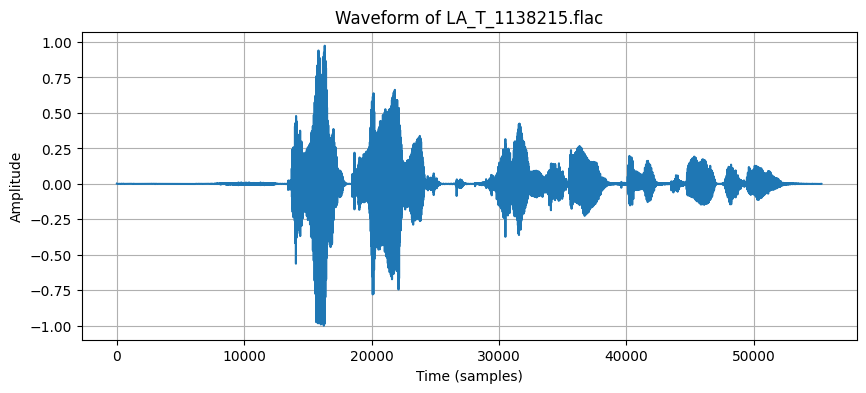

In [ ]:
def plot_waveform(audio_path):
    waveform, sr = torchaudio.load(audio_path)

    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(f"Waveform of {os.path.basename(audio_path)}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.show()

plot_waveform(train_data[0][0])


c:\Python312\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


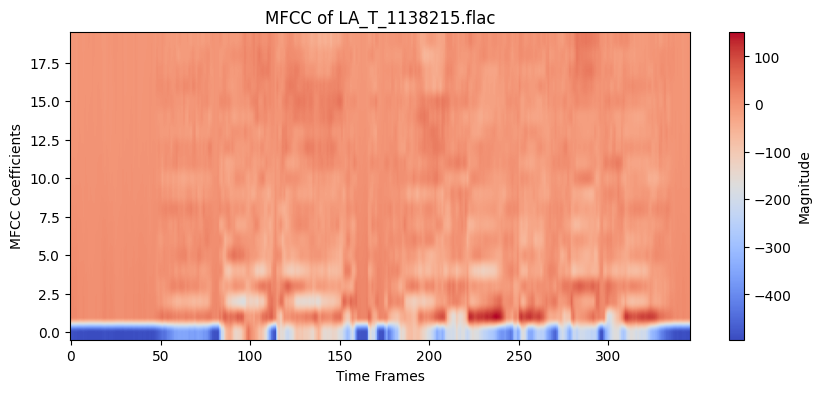

In [ ]:
def plot_mfcc(audio_path):
    mfcc = extract_mfcc(audio_path)

    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc, aspect="auto", origin="lower", cmap="coolwarm")
    plt.title(f"MFCC of {os.path.basename(audio_path)}")
    plt.xlabel("Time Frames")
    plt.ylabel("MFCC Coefficients")
    plt.colorbar(label="Magnitude")
    plt.show()

plot_mfcc(train_data[0][0])


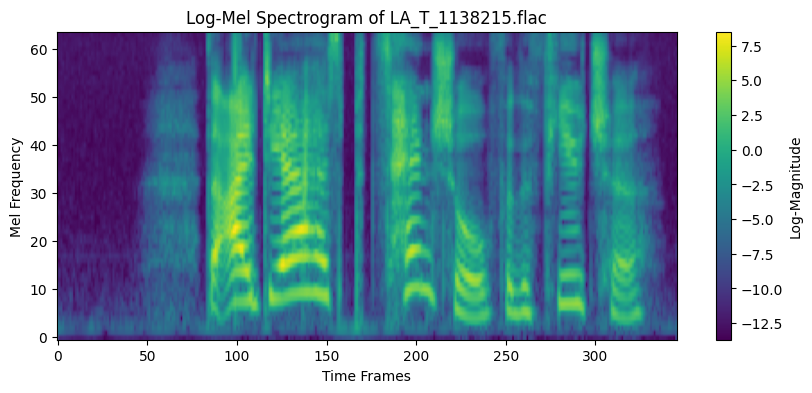

In [ ]:
def plot_logmel(audio_path):
    log_mel = extract_logmel(audio_path)

    plt.figure(figsize=(10, 4))
    plt.imshow(log_mel, aspect="auto", origin="lower", cmap="viridis")
    plt.title(f"Log-Mel Spectrogram of {os.path.basename(audio_path)}")
    plt.xlabel("Time Frames")
    plt.ylabel("Mel Frequency")
    plt.colorbar(label="Log-Magnitude")
    plt.show()


plot_logmel(train_data[0][0])


In [ ]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(
  "speechbrain/spkrec-xvect-voxceleb"
)

def extract_xvector_speechbrain(audio_path):
    try:
        # Load the audio file
        wave, sr = torchaudio.load(audio_path)
        
        # Ensure audio has the correct shape
        if wave.shape[0] > 1:  
            wave = torch.mean(wave, dim=0, keepdim=True)  # Convert to mono
        
        # Extract X-vector
        embeddings = classifier.encode_batch(wave).squeeze().detach().numpy()
        
        return embeddings
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Example usage
audio_sample = "ASVSpoof2019/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1000137.flac"
xvector = extract_xvector_speechbrain(audio_sample)

print("Extracted X-Vector Shape:", xvector.shape)


INFO:speechbrain.utils.fetching:Fetch hyperparams.yaml: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch custom.py: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch embedding_model.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch mean_var_norm_emb.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch classifier.ckpt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.fetching:Fetch label_encoder.txt: Fetching from HuggingFace Hub 'speechbrain/spkrec-xvect-voxceleb' if not cached
INFO:speechbrain.utils.parameter_transfer:Loading pretrained files for: embedding_model, mean_var_norm_emb, classifier, label_encoder


Extracted X-Vector Shape: (512,)


In [ ]:
def extract_xvector_speechbrain(audio_path):
    try:
        wave, sr = torchaudio.load(audio_path)
        
        # Convert to mono if stereo
        if wave.shape[0] > 1:
            wave = torch.mean(wave, dim=0, keepdim=True)
        
        # Extract X-vector
        embeddings = classifier.encode_batch(wave).squeeze().detach().numpy()
        return embeddings
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def process_dataset(data_path, protocol_path, output_file):
    xvectors = []
    labels = []
    
    with open(protocol_path, 'r') as f:
        protocol_lines = f.readlines()

    print(f"Processing {len(protocol_lines)} audio files from {data_path}...")
    
    for line in tqdm(protocol_lines):
        parts = line.strip().split()
        if len(parts) < 2:
            continue  
        
        utt_id = parts[1]  
        label = 1 if parts[-1] == "bonafide" else 0 

        audio_path = os.path.join(data_path, utt_id + ".flac")
        if not os.path.exists(audio_path):
            print(f"Warning: File not found {audio_path}")
            continue
        

        xvector = extract_xvector_speechbrain(audio_path)
        if xvector is not None:
            xvectors.append(xvector)
            labels.append(label)

    # Convert to NumPy arrays and save
    xvectors = np.array(xvectors)
    labels = np.array(labels)

    np.savez(output_file, xvectors=xvectors, labels=labels)
    print(f"X-vectors saved to {output_file} | Shape: {xvectors.shape}")

In [ ]:
classifier = EncoderClassifier.from_hparams(
    "speechbrain/spkrec-xvect-voxceleb"
)


train_data_path = r"ASVSpoof2019/LA/LA/ASVspoof2019_LA_train/flac"
train_protocol_path = r"ASVSpoof2019/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

test_data_path = r"ASVSpoof2019/LA/LA/ASVspoof2019_LA_eval/flac"
test_protocol_path = r"ASVSpoof2019/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"

process_dataset(train_data_path, train_protocol_path, "train_xvectors.npz")
process_dataset(test_data_path, test_protocol_path, "test_xvectors.npz")

In [21]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

In [ ]:

def load_data(xvector_file):
    data = np.load(xvector_file)
    xvectors = data['xvectors']
    labels = data['labels']
    return torch.tensor(xvectors, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)


train_x, train_y = load_data("train_xvectors.npz")
test_x, test_y = load_data("test_xvectors.npz")

batch_size = 32
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LightCNN(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(LightCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class SeNet(nn.Module):
    def __init__(self, input_dim=512, num_classes=2):
        super(SeNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.se = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.Sigmoid()
        )
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        se_weight = self.se(x)
        x = x * se_weight
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
model = LightCNN(input_dim=512, num_classes=2)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for x_batch, y_batch in progress_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{total_loss/len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    progress_bar = tqdm(test_loader, desc="Evaluating")
    with torch.no_grad():
        for x_batch, y_batch in progress_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")


In [33]:
# Train & Evaluate
train_model(model, train_loader, criterion, optimizer, epochs=50)
evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 2227/2227 [00:01<00:00, 1174.66it/s]

Test Accuracy: 93.96%


In [28]:
from sklearn.metrics import roc_curve
import numpy as np

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr 
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))] 
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]  
    return eer, eer_threshold


In [29]:
import torch.nn.functional as F

def evaluate_model_with_eer(model, test_loader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for x_batch, y_batch in tqdm(test_loader, desc="Evaluating for EER"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)  
            probabilities = F.softmax(outputs, dim=1)[:, 1]  #

            y_true.extend(y_batch.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    eer, eer_threshold = compute_eer(np.array(y_true), np.array(y_scores))
    print(f"Equal Error Rate (EER): {eer * 100:.2f}% at threshold {eer_threshold:.4f}")


In [34]:
evaluate_model_with_eer(model, test_loader)


Evaluating for EER: 100%|██████████| 2227/2227 [00:02<00:00, 1079.89it/s]

Equal Error Rate (EER): 9.87% at threshold 0.0019
